## CS4243 Assignment 2


In [35]:
import numpy as np
from skimage import filters
from skimage.feature import corner_peaks
import matplotlib.pyplot as plt
import cv2


## Part 1: Keypoint Matching & Homography
### Question 1

In [36]:
# Read left and right images
left_img = cv2.cvtColor(cv2.imread("data\\building_left.jpg"), cv2.COLOR_BGR2RGB)
right_img = cv2.cvtColor(cv2.imread("data\\building_right.jpg"), cv2.COLOR_BGR2RGB)
# plt.imshow(left_img)
left_img.shape

(683, 1024, 3)

In [37]:
# Set 1 keypoints
pts1 = np.array([[936, 652], [718, 646], [870, 349], [889, 634]])
pts2 = np.array([[464, 616], [254, 611], [424, 325], [422, 599]])

# Compute homography
H1, _ = cv2.findHomography(pts2, pts1)

# Set 2 keypoints
pts1 = np.array([[936, 652], [718, 646], [889, 634], [894, 623]])
pts2 = np.array([[464, 616], [254, 611], [422, 599], [430, 588]])

# Compute homography
H2, _ = cv2.findHomography(pts2, pts1)

print(H1)
print(H2)

[[ 7.13842070e-01  5.06927165e-02  4.49933241e+02]
 [-1.64096291e-01  9.07008199e-01  8.33141247e+01]
 [-2.58508030e-04 -1.96786785e-05  1.00000000e+00]]
[[ 5.78113458e-01 -6.35718591e-01  5.94628898e+02]
 [ 5.11399566e-02 -2.07400386e-02  3.17325365e+02]
 [ 7.66973065e-05 -8.63787353e-04  1.00000000e+00]]


(-0.5, 2047.5, 682.5, -0.5)

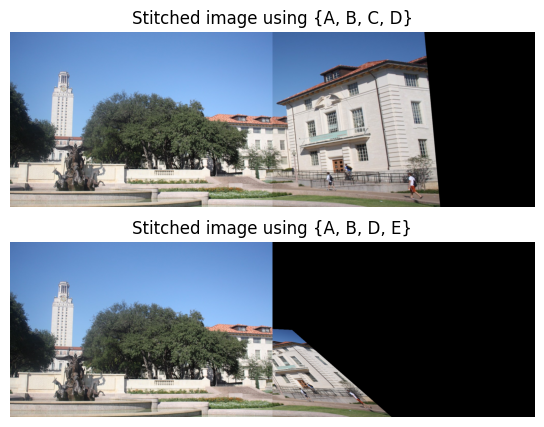

In [38]:
# Warp right image using H1
stitched1 = cv2.warpPerspective(right_img, H1, (left_img.shape[1]+right_img.shape[1], right_img.shape[0]))
stitched1[0:left_img.shape[0], 0:left_img.shape[1]] = left_img

stitched2 = cv2.warpPerspective(right_img, H2, (left_img.shape[1]+right_img.shape[1], right_img.shape[0]))
stitched2[0:left_img.shape[0], 0:left_img.shape[1]] = left_img


fig, axes = plt.subplots(2, 1, figsize=(15,5))

axes[0].imshow(stitched1)
axes[0].set_title('Stitched image using {A, B, C, D}')
axes[0].axis('off')

axes[1].imshow(stitched2)
axes[1].set_title('Stitched image using {A, B, D, E}')
axes[1].axis('off')

### Explain why the stitching from Set 2 fails:
A, B, D and E are very close to each other on the Y axis. Therefore, noise greatly affects the homography computed suing these keypoints, and cause significant vertical distortions.

### Question 2

5239 2519 5594


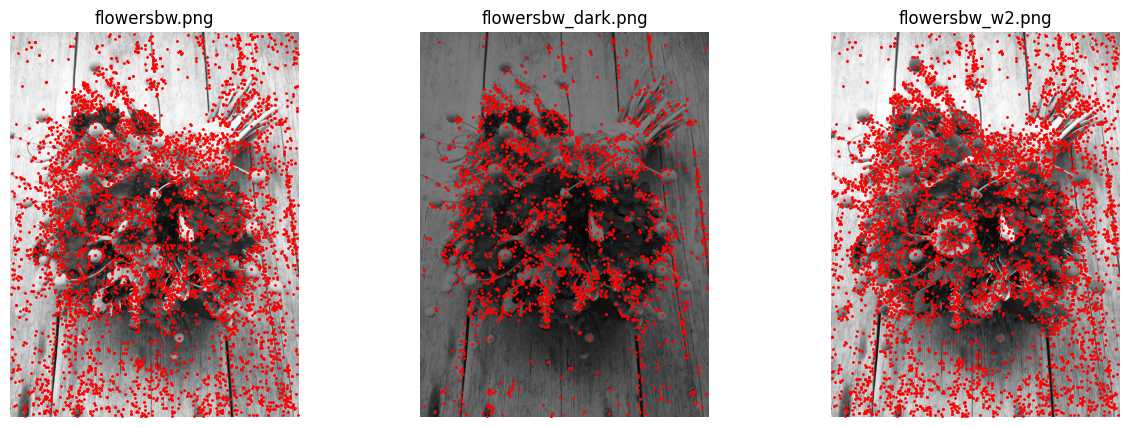

In [39]:
# Load the images
img_a = cv2.imread('data\\flowers.png')
img_b = cv2.imread('data\\flowersbw.png')
img_c = cv2.imread('data\\flowersbw_dark.png')
img_d = cv2.imread('data\\flowersbw_w2.png')

# Create SIFT detector and compute keypoints and descriptors
sift = cv2.SIFT_create()
kp_a, des_a = sift.detectAndCompute(img_a, None)
kp_b, des_b = sift.detectAndCompute(img_b, None)
kp_c, des_c = sift.detectAndCompute(img_c, None)
kp_d, des_d = sift.detectAndCompute(img_d, None)

# Visualize the keypoints as a scatterplot
fig, axes = plt.subplots(1, 3, figsize=(15,5))

axes[0].imshow(cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB))
axes[0].scatter([kp.pt[0] for kp in kp_b], [kp.pt[1] for kp in kp_b], s=1, color='red')
axes[0].set_title('flowersbw.png')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB))
axes[1].scatter([kp.pt[0] for kp in kp_c], [kp.pt[1] for kp in kp_c], s=1, color='red')
axes[1].set_title('flowersbw_dark.png')
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(img_d, cv2.COLOR_BGR2RGB))
axes[2].scatter([kp.pt[0] for kp in kp_d], [kp.pt[1] for kp in kp_d], s=1, color='red')
axes[2].set_title('flowersbw_w2.png')
axes[2].axis('off')

print(len(kp_b), len(kp_c), len(kp_d))

plt.show()

### Using the results of (b) as a reference, compare and comment on the number of keypoints and their locations for image (c) and (d).  Explain any differences that arise.
(c) has less keypoints detected that (b), while (d) has roughly the same number of keypoints detected as (b). The keypoints also appear in different locations. When the intensity is reduced like in (c), the keypoints change their location because the contrast in the image is reduced. However, this effect is small and most keypoints stay the same or shift slightly. 

2374 2110


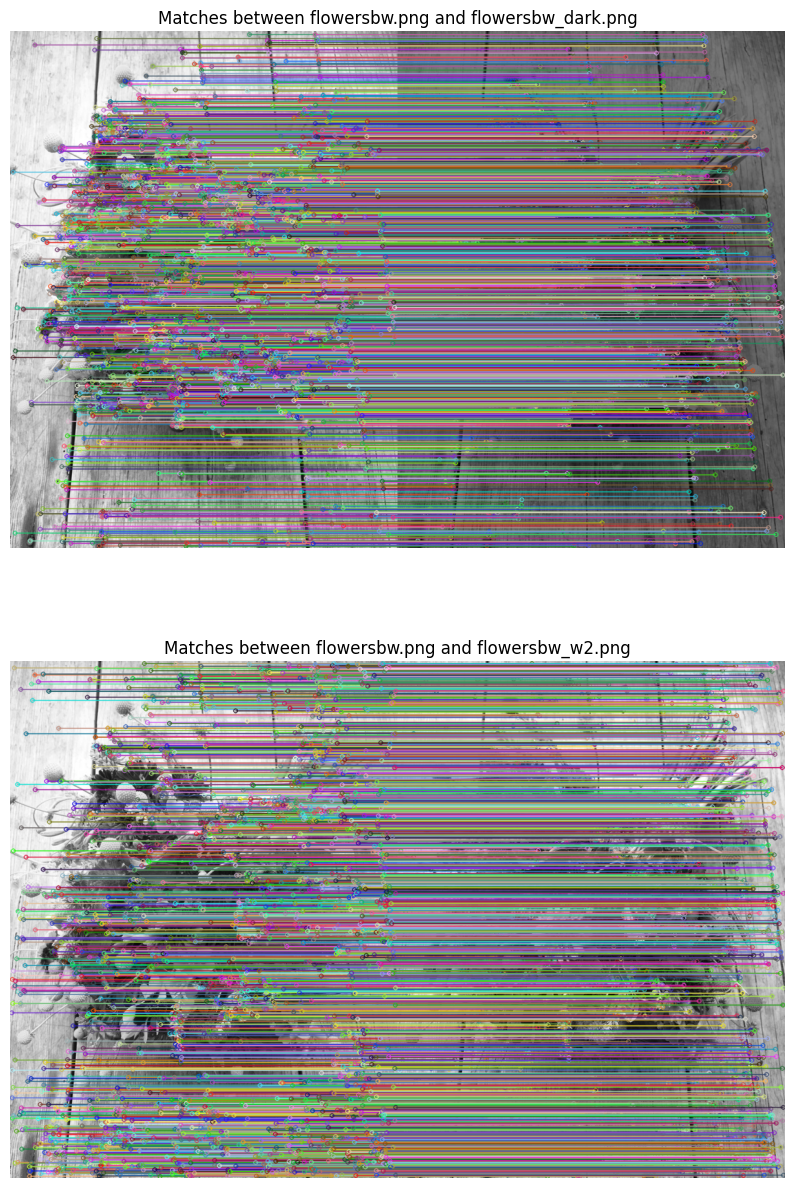

In [45]:
# Create BFMatcher object and perform matching
bf = cv2.BFMatcher()
matches_bc = bf.knnMatch(des_b, des_c, k=2)
matches_bd = bf.knnMatch(des_b, des_d, k=2)

# Apply ratio test
good_matches_bc = []
for m, n in matches_bc:
    if m.distance < 0.5 * n.distance:
        good_matches_bc.append([m])
        
good_matches_bd = []
for m, n in matches_bd:
    if m.distance < 0.5 * n.distance:
        good_matches_bd.append([m])
        
# Draw matched keypoints
img1 = cv2.drawMatchesKnn(img_b, kp_b, img_c, kp_c, good_matches_bc, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img2 = cv2.drawMatchesKnn(img_b, kp_b, img_d, kp_d, good_matches_bd, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
print(len(good_matches_bc), len(good_matches_bd))

# Show the images
fig, axes = plt.subplots(2, 1, figsize=(10,15))

axes[0].imshow(img1)
axes[0].set_title('Matches between flowersbw.png and flowersbw_dark.png')
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title('Matches between flowersbw.png and flowersbw_w2.png')
axes[1].axis('off')

plt.show()

# Compare and comment on the number of matched keypoints and their locations for the two image pairs. Explain any differences that arise.
The matchings have roughly the same number of keypoint matches. However, the matchings between flowersbw.png and flowersbw_dark.png has less keypoints on the background of the image compared to the matchings between flowersbw.png and flowersbw_w2.png.
The SIFT feature detector looks for local features such as gradient intensity and direction in an image. flowersbw_dark.png has low brightness and contrast, so these features may be harder to detect in the background of the image, where there is lower variation in intensity.

# Question 2

In [53]:
import csv

# Load the first frame and extract the pedestrian bounding boxes
frame = cv2.cvtColor(cv2.imread('data\\Crowd_PETS09\\frame_0000.jpg'), cv2.COLOR_BGR2RGB)
pedestrian_boxes = []
with open('data\\gt.csv') as csvfile:
    rows = csv.reader(csvfile, delimiter=',')
    for row in rows:
        if int(row[0]) == 0 and row[1] in ['9', '15', '19']:
            bbox = [float(row[2]), float(row[3]), float(row[4]), float(row[5])]
            pedestrian_boxes.append(bbox)

# Create trackers for each pedestrian in the first frame
trackers = []
for bbox in pedestrian_boxes:
    tracker = cv2.TrackerKCF_create()
    # tracker = cv2.TrackerMOSSE_create()
    tracker.init(frame, tuple(bbox))
    trackers.append(tracker)

# Loop over the rest of the frames and update the trackers
for i in range(1, 231):
    # Load the next frame and initialize the list of bounding boxes
    
    frame = cv2.cvtColor(cv2.imread('data\\Crowd_PETS09\\frame_{:04d}.jpg'.format(i)), cv2.COLOR_BGR2RGB)
    new_pedestrian_boxes = []

    # Update each tracker and save the new bounding box
    for j, tracker in enumerate(trackers):
        success, bbox = tracker.update(frame)
        if success:
            new_pedestrian_boxes.append(bbox)
        else:
            # If the tracker fails, remove it from the list
            trackers.pop(j)

    # If there are more pedestrian detections than trackers, create new trackers
    if len(new_pedestrian_boxes) > len(trackers):
        for bbox in new_pedestrian_boxes[len(trackers):]:
            tracker = cv2.TrackerKCF_create()
            # tracker = cv2.TrackerMOSSE_create()
            tracker.init(frame, tuple(bbox))
            trackers.append(tracker)

    # Draw the bounding boxes on the frame and save it
    for bbox in new_pedestrian_boxes:
        pt1 = (int(bbox[0]), int(bbox[1]))
        pt2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, pt1, pt2, (0, 255, 0), 2)
    cv2.imwrite('tracking\\{:04d}.jpg'.format(i), frame)


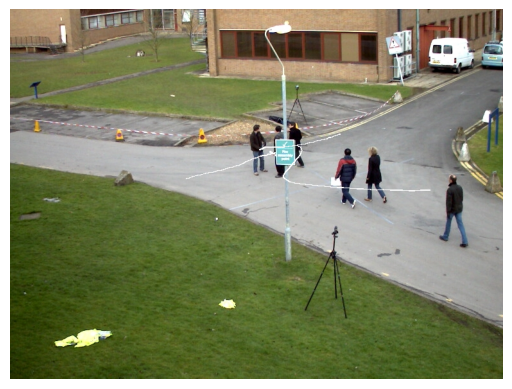

In [77]:
# code from visualization.py
import csv
from PIL import Image, ImageDraw
import numpy as np
frame_50 = Image.open('data/frame_0050.jpg')
labels = {}
with open('data/gt.csv') as csvfile:
    rows = csv.reader(csvfile, delimiter=',')
    for row in rows:
        if int(row[0]) <= 50 and row[1] in ['9', '15', '19']:
            if row[1] not in list(labels):
                labels[row[1]] = []
            labels[row[1]].append({'frame': int(row[0]), 'bb_left': float(row[2]), 'bb_top': float(row[3]), 'bb_width': float(row[4]), 'bb_height': float(row[5])})


draw = ImageDraw.Draw(frame_50)
for id in labels:
    points = []
    for bbox in labels[id]:
        cx = bbox['bb_left'] + bbox['bb_width']/2
        cy = bbox['bb_top'] + bbox['bb_height']/2
        points.append((int(cx), int(cy)))
    draw.line(points, width=2, fill='white')
    

frame_50.save('trajectory.png')

plt.axis('off')
plt.imshow(frame_50)